<a href="https://colab.research.google.com/github/dattali18/IR_Assignments/blob/main/Assignment.02/notebooks/IR_02_Classification_TFIDF-lemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IR Assignment 2

## Classification

### **Objective**:
  - Build classifiers to predict the journal group.

### **Algorithms**:
  - **Artificial Neural Network (ANN)** (two architectures provided):
      - ANN Architecture 1: RELU activation layers.
      - ANN Architecture 2: GELU activation layers.
  - **Other Classifiers**: Naive Bayes (NB), Support Vector Machine (SVM), Logistic Regression (LoR), Random Forest (RF).

### **Tasks**:
  - Perform 10-fold cross-validation for all classifiers (except ANN).
  - Identify and rank the top 20 most important features for NB, RF, SVM, LoR.
  - Write explanations for feature importance in a README document and include the ranked lists in an Excel file.
  - Check what is the top 20 most important features for NB, SVM, LoR, RF.

### **ANN Specifics**:
  - Split data: Train (80%, with 10% validation from the train set) and Test (20%).
  - Use the given ANN architectures with specific configurations:
      - Maximum 15 epochs.
      - Batch size: 32.
      - Early stopping after 3 validation iterations without improvement.
      - Save the best model (ModelCheckpoint).

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

df_aj = pd.read_excel("data/bm25_clean_A-J.xlsx")
df_bbc = pd.read_excel("data/bm25_clean_BBC.xlsx")
df_nyt = pd.read_excel("data/bm25_clean_NY-T.xlsx")
df_jp = pd.read_excel("data/bm25_clean_J-P.xlsx")

df_aj.head()

,DocumentIndex,israel,said,gaza,israeli,hamas,rsquo,ldquo,rdquo,war,...,inconsistencies,kindertransport,longest-serving,indiscriminately,american-supplied,behind-the-scenes,counterproductive,counterprotesters,interdisciplinary,counter-protesters
0,0,0.00000,0.0,1.893326,0.373610,0.0,0,0,0,0.0000,...,0,0,0,0,0,0.0,0,0,0,0.0
1,1,0.18534,0.0,0.000000,0.377472,0.0,0,0,0,0.0000,...,0,0,0,0,0,0.0,0,0,0,0.0
2,2,0.00000,0.0,1.950967,0.648199,0.0,0,0,0,0.0000,...,0,0,0,0,0,0.0,0,0,0,0.0
3,3,0.00000,0.0,1.338546,0.000000,0.0,0,0,0,0.0557,...,0,0,0,0,0,0.0,0,0,0,0.0
4,4,0.00000,0.0,2.077459,0.591964,0.0,0,0,0,0.0000,...,0,0,0,0,0,0.0,0,0,0,0.0


In [4]:
# df_bbc = pd.read_excel("data/bm25_clean_BBC.xlsx")
# df_nyt = pd.read_excel("data/bm25_clean_NY-T.xlsx")
# df_jp = pd.read_excel("data/bm25_clean_J-P.xlsx")

print(df_bbc.shape)
print(df_nyt.shape)
print(df_jp.shape)

(549, 7975)
(599, 7975)
(599, 7975)


In [5]:
# create a new df where we concat all the 4 other df but before we add a 'sheet'
# col with aj for aj etc
# remove the DocumentIndex col
# and instead add an id of aj_<index> bbc_<index>

# create an id col
df_aj['id'] = 'aj_' + df_aj['DocumentIndex'].astype(str)
df_bbc['id'] = 'bbc_' + df_bbc['DocumentIndex'].astype(str)
df_nyt['id'] = 'nyt_' + df_nyt['DocumentIndex'].astype(str)
df_jp['id'] = 'jp_' + df_jp['DocumentIndex'].astype(str)

# remove the DocumentIndex col
df_aj = df_aj.drop(columns=['DocumentIndex'])
df_bbc = df_bbc.drop(columns=['DocumentIndex'])
df_nyt = df_nyt.drop(columns=['DocumentIndex'])
df_jp = df_jp.drop(columns=['DocumentIndex'])

# add an sheet col
df_aj['Sheet'] = 'A-J'
df_bbc['Sheet'] = 'BBC'
df_nyt['Sheet'] = 'NY-T'
df_jp['Sheet'] = 'J-P'

# concat all the 4 df
df = pd.concat([df_aj, df_bbc, df_nyt, df_jp])

df.shape

(2346, 7976)

In [6]:
# reorder the col to have id and Sheet col to the start
df = df[['id', 'Sheet'] + [col for col in df.columns if col not in ['id', 'Sheet']]]

df.head()

,id,Sheet,israel,said,gaza,israeli,hamas,rsquo,ldquo,rdquo,...,inconsistencies,kindertransport,longest-serving,indiscriminately,american-supplied,behind-the-scenes,counterproductive,counterprotesters,interdisciplinary,counter-protesters
0,aj_0,A-J,0.00000,0.0,1.893326,0.373610,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aj_1,A-J,0.18534,0.0,0.000000,0.377472,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aj_2,A-J,0.00000,0.0,1.950967,0.648199,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aj_3,A-J,0.00000,0.0,1.338546,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aj_4,A-J,0.00000,0.0,2.077459,0.591964,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# create the vector col
df['vector'] = df.iloc[:, 2:].values.tolist()

df.head()

,id,Sheet,israel,said,gaza,israeli,hamas,rsquo,ldquo,rdquo,...,kindertransport,longest-serving,indiscriminately,american-supplied,behind-the-scenes,counterproductive,counterprotesters,interdisciplinary,counter-protesters,vector
0,aj_0,A-J,0.00000,0.0,1.893326,0.373610,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.893326376881906, 0.37361009867568..."
1,aj_1,A-J,0.18534,0.0,0.000000,0.377472,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.1853396197512515, 0.0, 0.0, 0.3774716369817..."
2,aj_2,A-J,0.00000,0.0,1.950967,0.648199,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.950966635001597, 0.64819920982025..."
3,aj_3,A-J,0.00000,0.0,1.338546,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.338545880678982, 0.0, 0.0, 0.0, 0..."
4,aj_4,A-J,0.00000,0.0,2.077459,0.591964,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 2.07745855842562, 0.591964341640264..."


In [8]:
# standerdize the data mean=0 std=1
import numpy as np

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# apply to each line of the df

df['std_vector'] = df['vector'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten())
df['std_vector'].head()

,std_vector
0,"[-0.054619953467782575, -0.054619953467782575,..."
1,"[0.7424595017498579, -0.05817892126005486, -0...."
2,"[-0.05898953471048584, -0.05898953471048584, 8..."
3,"[-0.055352259781569685, -0.055352259781569685,..."
4,"[-0.053095707056546, -0.053095707056546, 8.296..."


In [9]:
# visualize the real cluster using t-SNE

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)

# transofrm the df['vector'] to dataframe with freatuer 0 - 99 for
df_copy = df['std_vector'].apply(pd.Series)

df_tsne = tsne.fit_transform(df_copy)

df_tsne = pd.DataFrame(df_tsne, columns=['x', 'y'])

KeyError: 'cluster'

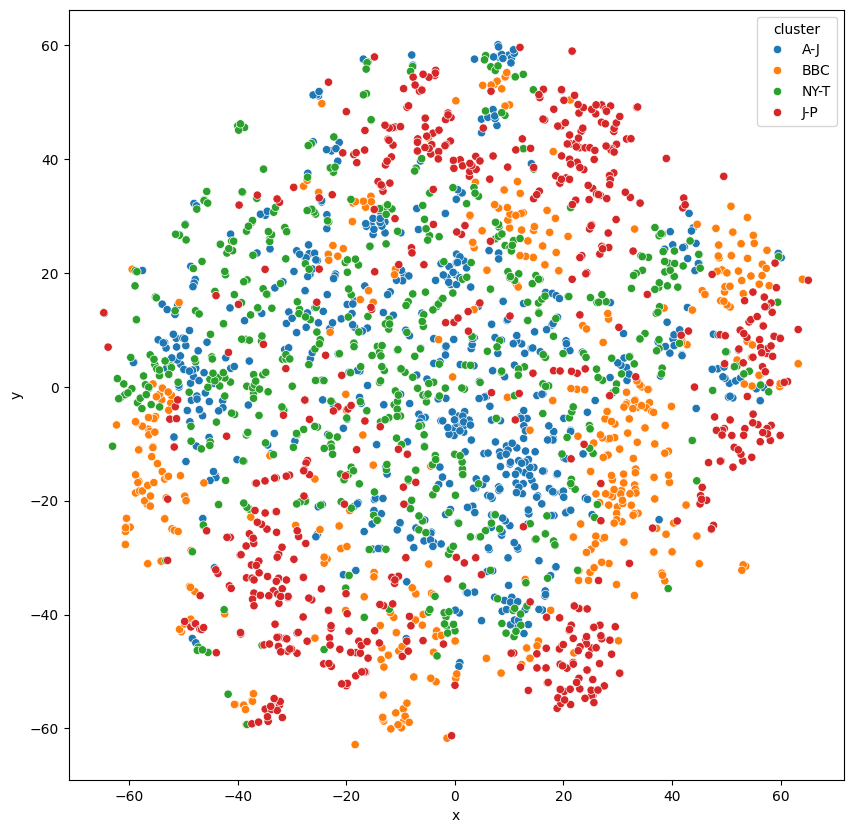

In [12]:
# plot the data
import matplotlib.pyplot as plt
import seaborn as sns

df_tsne['cluster'] = df['Sheet'].values

plt.figure(figsize=(10, 10))

sns.scatterplot(data=df_tsne, x="x", y="y", hue="cluster")

plt.show()

In [13]:
# import all the the needed libraries NaiveBayes, SVM, LoR, RF
data = df['std_vector'].tolist()

In [14]:
data = np.array(data)

In [15]:
type(data)

numpy.ndarray

In [16]:
data.shape

(2346, 7974)

In [19]:
df['cluster'] = df['Sheet'].map({'A-J': 0, 'BBC': 1, 'NY-T': 2, 'J-P': 3})

## Naive Bayes Classifier

In [20]:
# naive bayes
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X = data
y = df['cluster'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.29, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train type:", type(X_train))
print("y_train type:", type(y_train))

X_train shape: (1665, 7974)
y_train shape: (1665,)
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>


In [21]:
# use Naive Bayes with 10-fold cross validation
from sklearn.model_selection import cross_val_score

gnb = GaussianNB()

scores = cross_val_score(gnb, X_train, y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.54 (+/- 0.08)


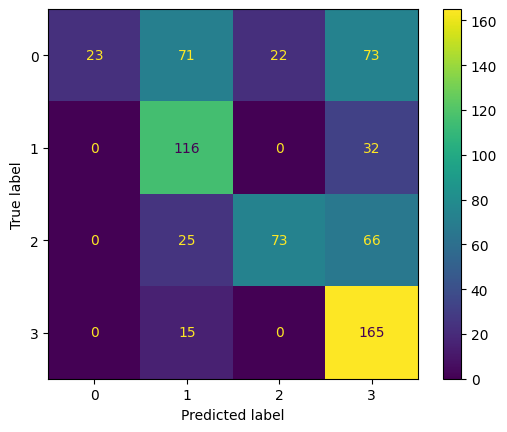

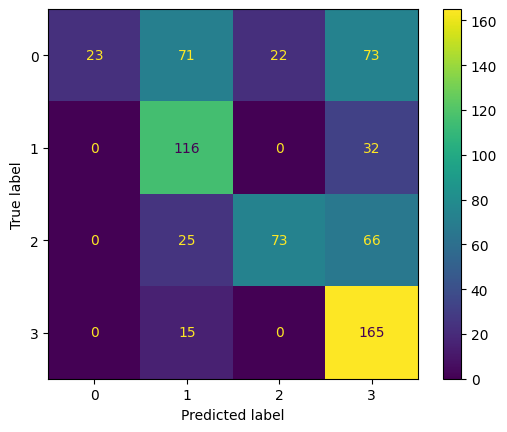

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

gnb.fit(X_train, y_train)

disp = ConfusionMatrixDisplay.from_estimator(gnb, X_test, y_test)

disp.plot()

plt.show()

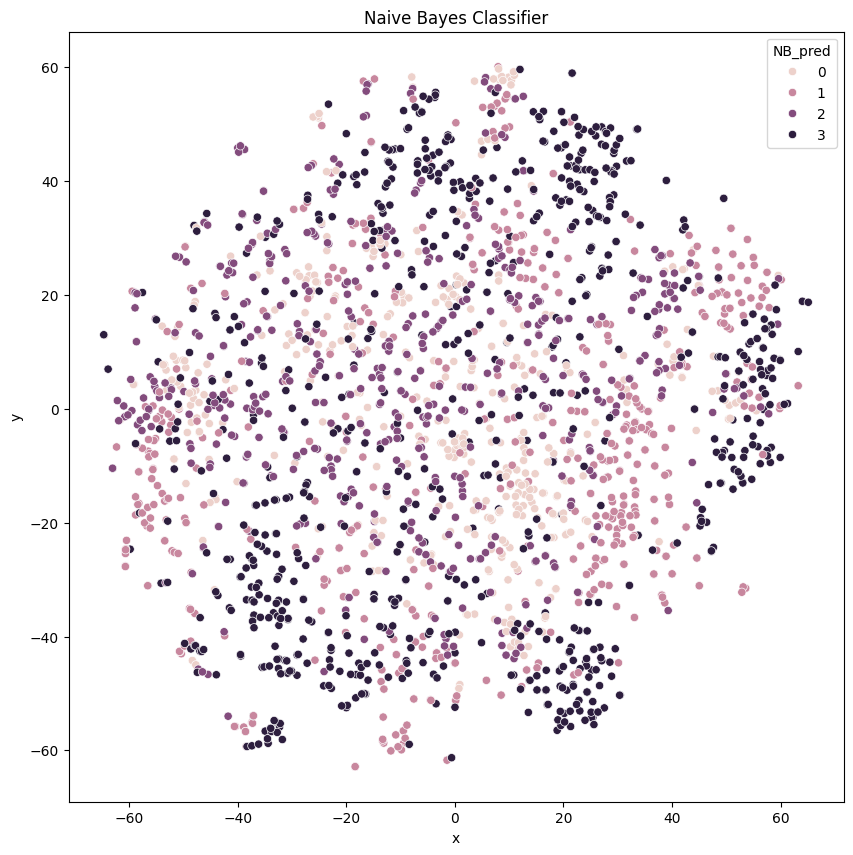

In [23]:
# get the calssification report for all X from the model and color the results using the tsne plot
df_tsne['NB_pred'] = gnb.predict(X)


plt.figure(figsize=(10, 10))

#  add title
plt.title("Naive Bayes Classifier")

sns.scatterplot(data=df_tsne, x="x", y="y", hue="NB_pred")

plt.show()

## SVM - Support Vector Machine

In [24]:
# use SVM with 10-fold cross validation
from sklearn.svm import SVC

svc = SVC()

scores = cross_val_score(svc, X_train, y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.06)


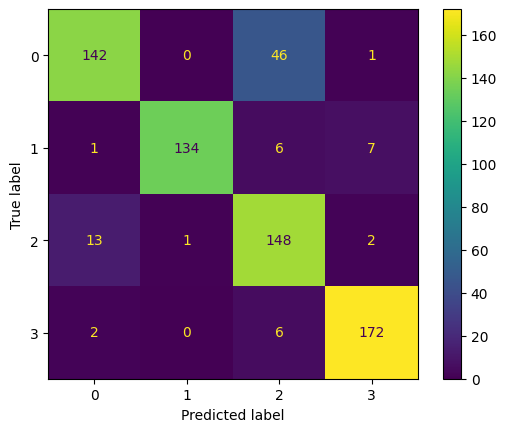

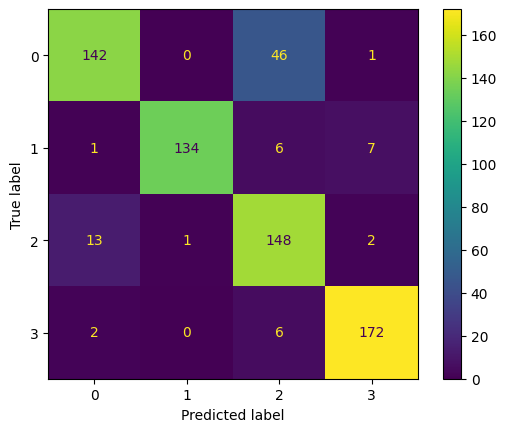

In [25]:
# same as NB

svc.fit(X_train, y_train)

disp = ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test)

disp.plot()

plt.show()

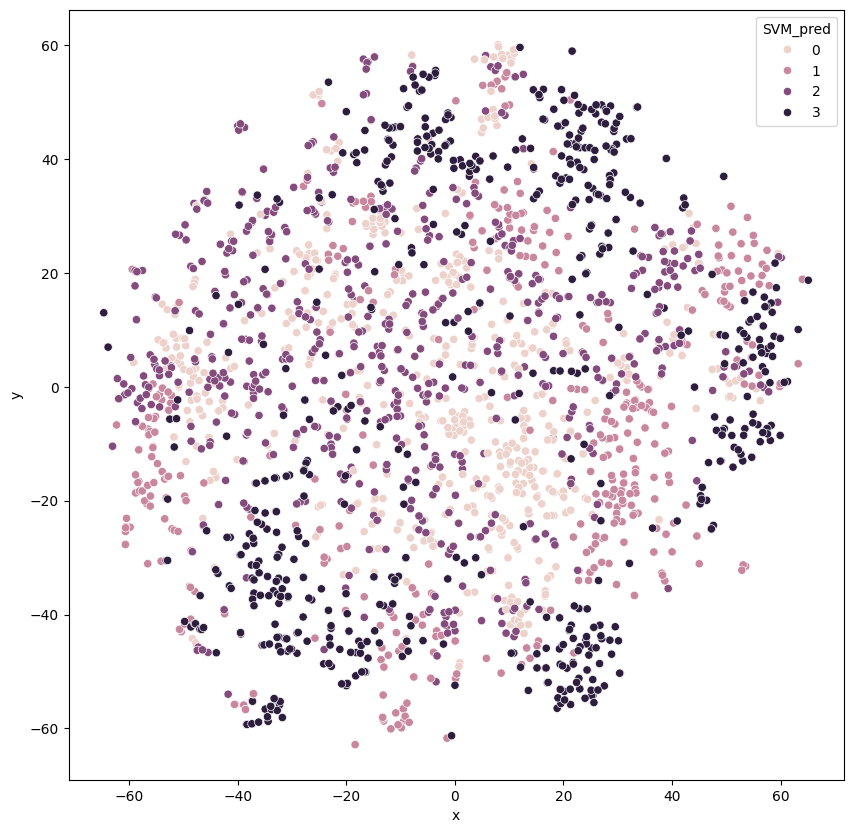

In [26]:
# get the calssification report for all X from the model and color the results using the tsne plot
df_tsne["SVM_pred"] = svc.predict(X)


plt.figure(figsize=(10, 10))

sns.scatterplot(data=df_tsne, x="x", y="y", hue="SVM_pred")

plt.show()

## Logistic Regression

In [27]:
# use Logistic Regression with 10-fold cross validation

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

scores = cross_val_score(lr, X_train, y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.05)


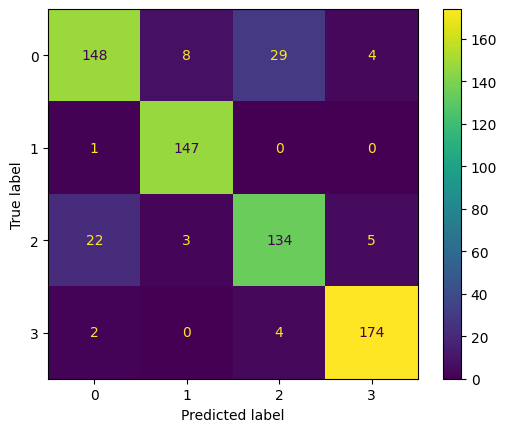

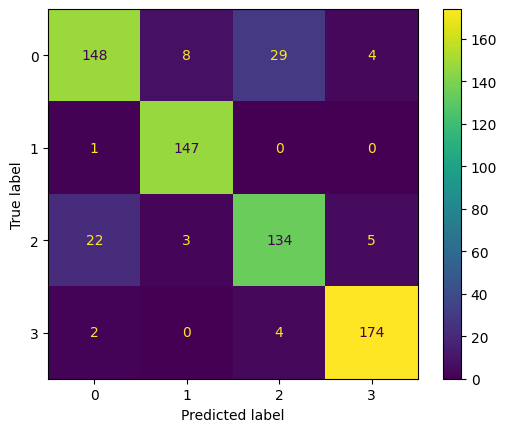

In [28]:
# same

# visualize the results of the classification for all the X

lr.fit(X_train, y_train)

disp = ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)

disp.plot()

plt.show()

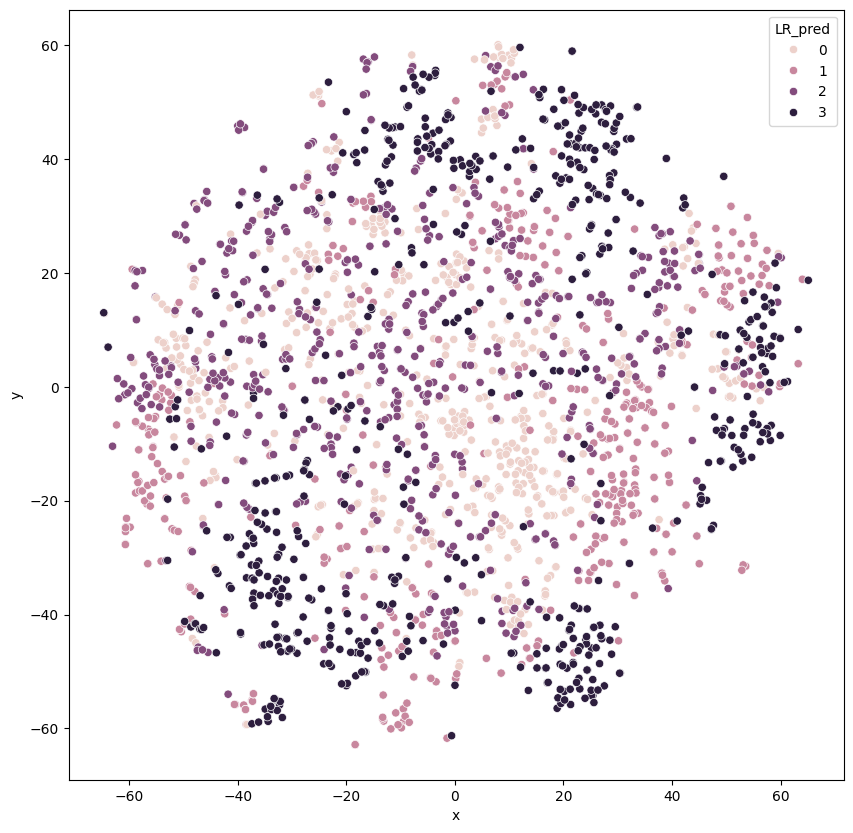

In [29]:
# plot the results using tsne

df_tsne["LR_pred"] = lr.predict(X)

plt.figure(figsize=(10, 10))

sns.scatterplot(data=df_tsne, x="x", y="y", hue="LR_pred")

plt.show()

# RF - Random Forest Classifier

In [30]:
# use Random Forest with 10-fold cross validation

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

scores = cross_val_score(rf, X_train, y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.97 (+/- 0.03)


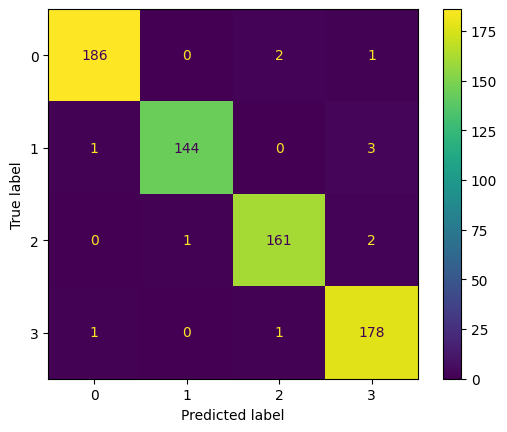

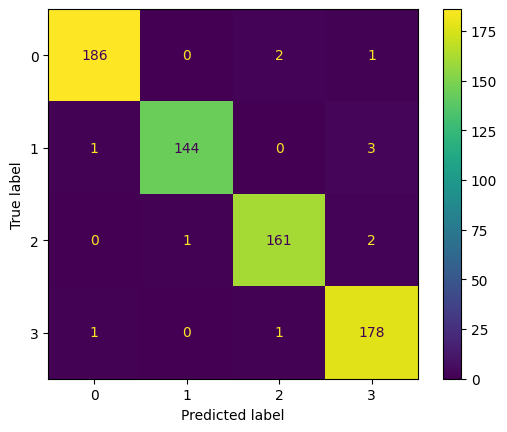

In [31]:
# same

# visualize the results of the classification for all the X

rf.fit(X_train, y_train)

disp = ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)

disp.plot()

plt.show()

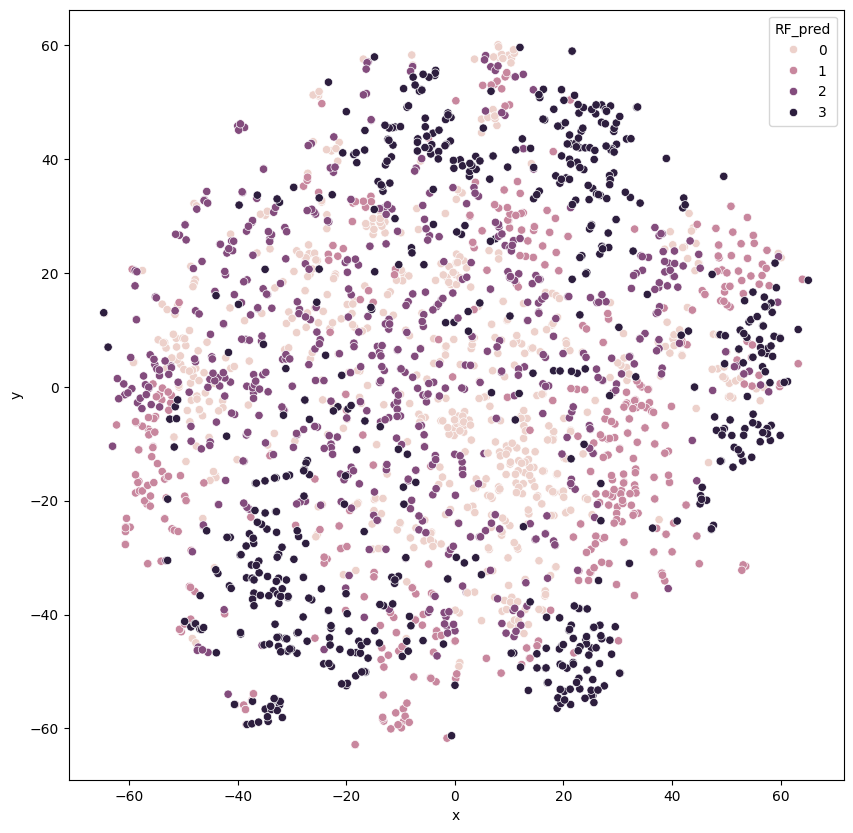

In [32]:
# plot the results using tsne

df_tsne["RF_pred"] = rf.predict(X)

plt.figure(figsize=(10, 10))

sns.scatterplot(data=df_tsne, x="x", y="y", hue="RF_pred")

plt.show()

# ANN - Artificial Neural Network Classifier

We will build a NN using `tensorflow` and `keras` to classify the journal group.

The architecture of the NN is as follows:

- Embedding layer with 100 input dimensions.
- Hidden layer with 10 node and `relu` activation function.
- Hidden layer with 10 node and `relu` activation function.
- Hidden layer with 7 node and `relu` activation function.
- Output layer with 4 nodes and `softmax` activation function. (4 classes)

Seconde architecture:

- Embedding layer with 100 input dimensions.
- Hidden layer with 10 node and `gelu` activation function.
- Hidden layer with 10 node and `gelu` activation function.
- Hidden layer with 7 node and `gelu` activation function.
- Output layer with 4 nodes and `softmax` activation function. (4 classes)

In [33]:
X = X.astype(np.float32)
y = y.astype(int)

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense

model_1 = Sequential([
    Dense(100, activation='relu', input_shape=(X.shape[1],)),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(7, activation='relu'),
    Dense(4, activation='softmax')
])

# compile the model
model_1.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# fit the model
history = model_1.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.2841 - loss: 1.3525 - val_accuracy: 0.4229 - val_loss: 1.1422
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5456 - loss: 1.0109 - val_accuracy: 0.7633 - val_loss: 0.8064
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8108 - loss: 0.6264 - val_accuracy: 0.8590 - val_loss: 0.6165
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9537 - loss: 0.3358 - val_accuracy: 0.8644 - val_loss: 0.4471
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9864 - loss: 0.0720 - val_accuracy: 0.8803 - val_loss: 0.4162
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9930 - loss: 0.0293 - val_accuracy: 0.8856 - val_loss: 0.3877
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0127 - val_accuracy: 0.8750 - val_loss: 0.4221
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9938 - loss: 0.0136 - val_accuracy: 0.8723 - val_los

In [36]:
# model 2

model_2 = Sequential(
    [
        Dense(100, activation="gelu", input_shape=(X.shape[1],)),
        Dense(10, activation="gelu"),
        Dense(10, activation="gelu"),
        Dense(7, activation="gelu"),
        Dense(4, activation="softmax"),
    ]
)

# compile the model
model_2.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# fit the model
history = model_2.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.3817 - loss: 1.2878 - val_accuracy: 0.6702 - val_loss: 0.9129
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7734 - loss: 0.6561 - val_accuracy: 0.7819 - val_loss: 0.6595
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9345 - loss: 0.2103 - val_accuracy: 0.8138 - val_loss: 0.6160
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9829 - loss: 0.0554 - val_accuracy: 0.8085 - val_loss: 0.7881
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0122 - val_accuracy: 0.7872 - val_loss: 0.7864
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0044 - val_accuracy: 0.7899 - val_loss: 0.7934
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0031 - val_accuracy: 0.7899 - val_loss: 0.8111
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0024 - val_accuracy: 0.7793 - val_loss

In [37]:
# check the accuracy of the models

# model 1
loss, accuracy = model_1.evaluate(X_test, y_test)

print("Model 1 Accuracy: ", accuracy)

# model 2

loss, accuracy = model_2.evaluate(X_test, y_test)

print("Model 2 Accuracy: ", accuracy)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8138 - loss: 0.5658
Model 1 Accuracy:  0.8191489577293396
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7848 - loss: 0.8849
Model 2 Accuracy:  0.785106360912323


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


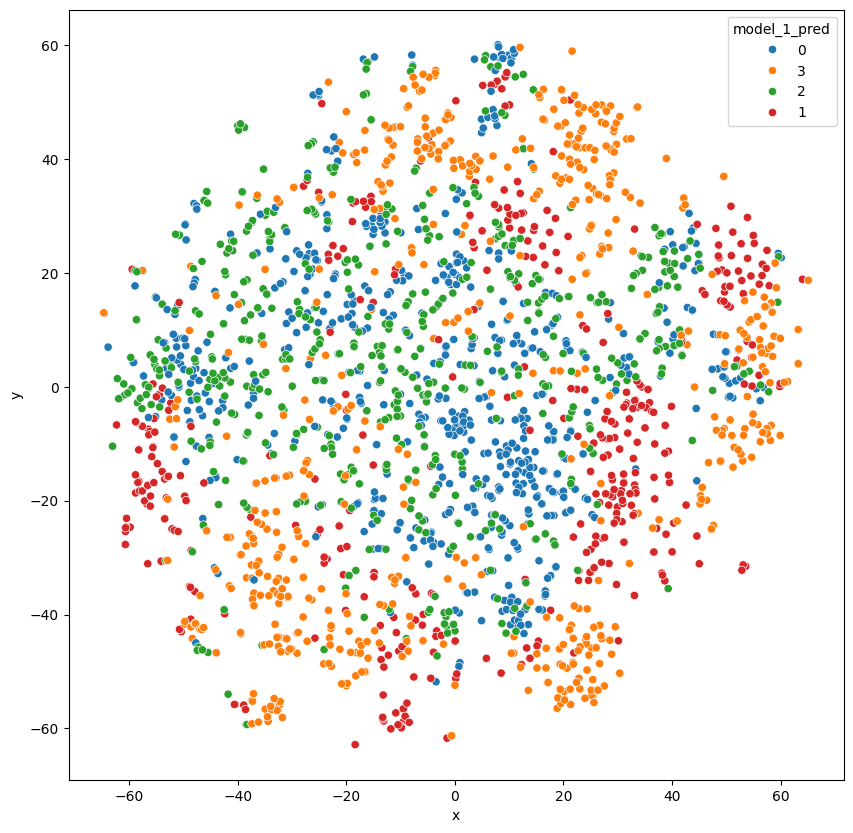

In [38]:
# plot the prediction for model 1

predictions = model_1.predict(X)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)


df_tsne["model_1_pred"] = [str(cls) for cls in predicted_classes]

plt.figure(figsize=(10, 10))

sns.scatterplot(data=df_tsne, x="x", y="y", hue="model_1_pred")

plt.show()

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


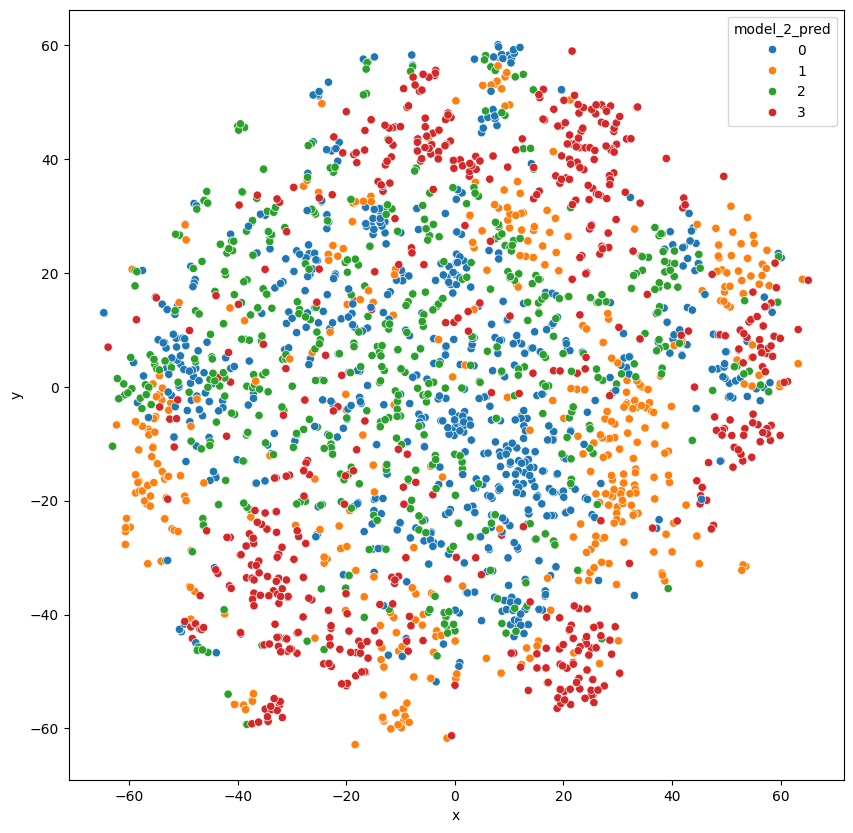

In [39]:
# plot the prediction for model 1

predictions = model_2.predict(X)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)


df_tsne["model_2_pred"] = [str(cls) for cls in predicted_classes]

plt.figure(figsize=(10, 10))

sns.scatterplot(data=df_tsne, x="x", y="y", hue="model_2_pred")

plt.show()

In [40]:
# save the model into a file

model_1.save("model_1_doc2vec.h5")

model_2.save("model_2_doc2vec.h5")